In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [2]:
def generate(N, rva, rvb, rv_outlier, p_outliers=0.01):
    rv_outlier_happens = st.bernoulli(p_outliers)
    
    base = rva.rvs(N)
    candidate = rvb.rvs(N)
    
    outliers_base = rv_outlier_happens.rvs(N) * rv_outlier.rvs(N)
    outliers_candidate = rv_outlier_happens.rvs(N) * rv_outlier.rvs(N)
    
    return base - candidate, outliers_base - outliers_candidate

def calculate_performance(y, outliers, threshold):
    N_outliers = len(outliers[outliers != 0])
    if N_outliers == 0:
        return None, None
    found = len(y[(np.abs(y) > threshold)])
    recall = len(y[(np.abs(y) > threshold) & (outliers != 0)]) / N_outliers
    precision = len(y[(np.abs(y) > threshold) & (outliers != 0)]) / found
    return precision, recall, found

def filter_symmetrical_outliers(data):
    def inner_pass(data, counts):
        """
        counts - (a, b) tuple of two counters with the number of registered outliers on
                 baseline and canidate
        """
        base_count, candidate_count = counts
        if base_count + candidate_count > len(data) * 0.4:
            # print("Stopping because it's too deep")
            return None, None
            
        if len(data) < 2:
            # print("Stopping because there is no more samples")
            return None, None

        #print(y)
        #print(data[0], data[-1])
        var = np.var(data)
        reduced_data, base_count, candidate_count = (data[1:], base_count + 1, candidate_count) if abs(data[0]) > abs(data[-1]) \
            else (data[:-1], base_count, candidate_count + 1)
        reduced_var = np.var(reduced_data)

        threshold = max(abs(data[1]), abs(data[-2]))
        # Check if ignoring the outlier will reduce variance
        if (var / reduced_var) < 1.3:
            #print("Stopping because variance stop shrinking")
            return inner_pass(reduced_data, (base_count, candidate_count))
        reduction = var / reduced_var
        
        # print(f"Var reduction is: {reduction:5.2} as threshold: {threshold:.2f}")
        
        # Check if distribution of outliers is random enough
        rv = st.binom(base_count + candidate_count, 0.5)
        i_min, i_max = rv.interval(0.9);
        
        #print(f"Counts: {base_count} {candidate_count}")
        #print(f"Interval: {i_min} - {i_max}")

        if min(base_count, candidate_count) < i_min:
            # print(f"Stopping because outliers are not symmetrical {base_count} {candidate_count}")
            return inner_pass(reduced_data, (base_count, candidate_count))
        else:
            proposed_threshold, proposed_reduction = inner_pass(reduced_data, (base_count, candidate_count))
            if proposed_threshold and proposed_reduction > reduction:
                return proposed_threshold, proposed_reduction
            else:
                return threshold, reduction

    data = data.copy()
    data.sort()
    threshold, _ = inner_pass(data[1:-1], (0, 0))
    return threshold

#filter_symmetrical_outliers(y)

Outliers: 21, found: 23, threshold: 64.82
Precision: 91.3, recall: 100.0


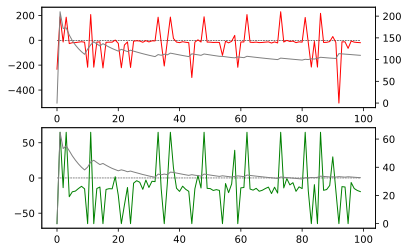

In [29]:
rva = st.lognorm(2, loc=50)
rvb = st.lognorm(2, loc=65)
rvo = st.lognorm(4, loc=200)
N = 100

real_y, outliers = generate(N, rva, rvb, rvo, 0.1)
y = real_y + outliers

x = np.arange(0, N)

threshold = filter_symmetrical_outliers(y)

if threshold:
    precision, recall, outliers_found = calculate_performance(y, outliers, threshold)
    if precision and recall:
        print(f"Outliers: {len(outliers[outliers != 0])}, found: {outliers_found}, threshold: {threshold:.2f}")
        print(f"Precision: {precision * 100:.1f}, recall: {recall * 100:.1f}")
else:
    print("No outliers were found")

if threshold:
    filtered_y = np.clip(y, -threshold, threshold)
else:
    filtered_y = y

cum_var = [np.var(y[:i+1]) for i in np.arange(0, N)]
filtered_cum_var = [np.var(filtered_y[:i+1]) for i in np.arange(0, N)]

fig, axs = plt.subplots(2, figsize=(6,4))

axs[0].plot(x, [0] * N, '--', color='black', linewidth=0.5)
axs[0].plot(x, y, linewidth=1, color="red")
ax = axs[0].twinx()
ax.plot(x, np.sqrt(cum_var), linewidth=1, color="gray")

axs[1].plot(x, [0] * N, '--', color='black', linewidth=0.5)
axs[1].plot(filtered_y, linewidth=1, color="green")
ax = axs[1].twinx()
ax.plot(x, np.sqrt(filtered_cum_var), linewidth=1, color="gray")

plt.show()

In [17]:
prec_sum = 0
rec_sum = 0
iter = 100
for i in range(0, iter):
    real_y, outliers = generate(N, rva, rvb, rvo, 0.1)
    y = real_y + outliers
    threshold = filter_symmetrical_outliers(y)
    if threshold:
        precision, recall, outliers_found = calculate_performance(y, outliers, threshold)
        if precision and recall:
            prec_sum += precision
            rec_sum += recall

print(f"Average precision: {prec_sum / iter:.2f}, recall: {rec_sum / iter:.2f}")

Average precision: 0.82, recall: 0.83


/tmp/ipykernel_192/2395818813.py:10: RuntimeWarning: divide by zero encountered in divide
  ratio = np.roll(forward_var, -1) / forward_var
/tmp/ipykernel_192/2395818813.py:17: RuntimeWarning: divide by zero encountered in log
  ax[0].plot(x, np.log(forward_var))


21


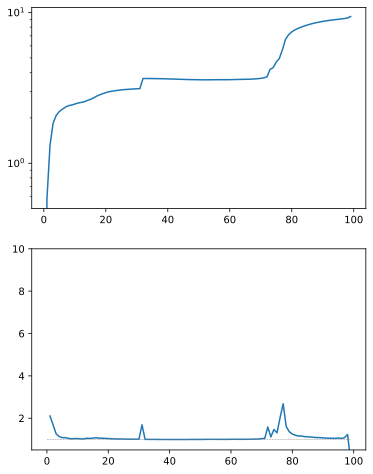

In [31]:
def var_at(data, idx):
    return np.var(data[:idx]), np.var(data[idx:])

def cum_var(input):
    return np.array([np.var(input[:i+1]) for i in np.arange(0, len(input))])

def plot_cumulative_var(input):
    input = input[np.abs(input).argsort()]
    forward_var = cum_var(input)
    ratio = np.roll(forward_var, -1) / forward_var

    backward_var = np.roll(np.flip(cum_var(np.flip(input))), -1);
    
    x = np.arange(0, N)

    f, ax = plt.subplots(2, figsize=(6,8))
    ax[0].plot(x, np.log(forward_var))
    ax[0].set_yscale("log")
    
    ax[1].plot(x, ratio)
    ax[1].plot(x, [1] * N, '--', color="gray", linewidth=0.5)
    ax[1].set_ylim(0.5, 10)
    # ax[1].set_yscale("log")

    f.show()

plot_cumulative_var(y)
print(len(outliers[outliers != 0]))

In [23]:
data = np.array([1,1,1,1,1,2,3,100,101,102,100,100,100])
# data = y

forward_var = cum_var(data)
backward_var = np.roll(np.flip(cum_var(np.flip(data))), -1);
print(forward_var[1:-2])
print(backward_var[1:-2])

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.38888889e-01 5.30612245e-01 1.06318750e+03 1.69691358e+03
 2.08261000e+03 2.28333884e+03]
[2.42570248e+03 2.34100000e+03 2.15666667e+03 1.80125000e+03
 1.16453061e+03 5.83333333e-01 6.40000000e-01 7.50000000e-01
 0.00000000e+00 0.00000000e+00]


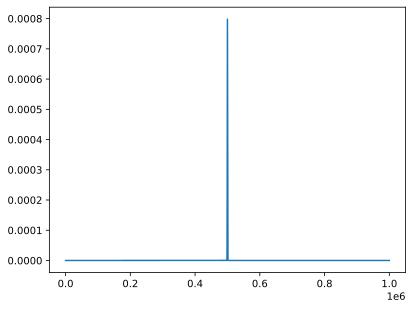

In [13]:
b = st.binom(1000000, 0.5)
x = np.arange(0, 1000000)
plt.plot(x, b.pmf(x))

In [46]:
np.var([1,2, 12])

24.666666666666668

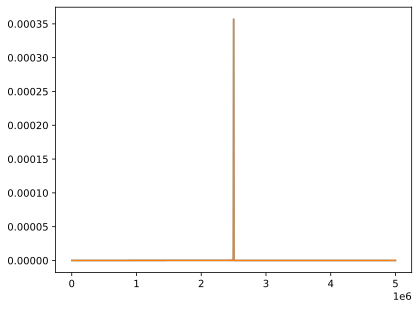

In [20]:
n = 5000000
p = 0.5

mu = n * p
sigma = np.sqrt(n * p * (1 - p))
d_n = st.distributions.norm(mu, sigma)
d_b = st.distributions.binom(n, p)

x = np.arange(0, n)

plt.plot(x, d_n.pdf(x))
plt.plot(x, d_b.pmf(x))

In [26]:
n = 10000000
p = 0.5

d_b = st.distributions.binom(n, p)

d_b.interval(0.8)

(4997974.0, 5002026.0)